# **Disclaimer:**  
> The dataset presented in this project has been **simulated** to protect proprietary or confidential company information.  
> While the data values do not correspond to real project information, the structure, methodology, and analytical approach are consistent with the original real-world project.  
> The insights and findings reflect the actual outcomes of the real project, with only the underlying data replaced.  
.  
  


### Purpose & Process
The goal of this analysis is to quantify the potential downside risk in project budget variance (measured as Value at Risk at different confidence levels) to support financial forecasting, cost control, and risk management decisions.

#### Process followed:

Data Collection & Preparation: Imported historical change orders, project characteristics including budgets, and the administrative communications of the projects.

Exploratory Analysis: Visualized response variable inclduing breakdown by funding type plotted against change order count and the numbder of administative forms, and reviewed statistical characterics of quanitative variables.

Modeling Approach: Applied OLS to review linear models statistics and applied Linear Regression for a monte carlo simulation with the Value at Risk 95 and 99 percentiles savded in a dataframe for analysis.

Evaluation & Interpretation: Assessed model fit, variable performance and applied three visual approches (boxplot, scatter plot, and line plot) to check general perfomance and review areas of primary concern.

Findings & Recommendations: Summarized key insights and proposed next steps for risk management and further model improvement.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [4]:
# Import preprocessing, modeling, evaluation, and tuning tools from scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
# Load datasets from CSV files
ai = pd.read_csv("action items.csv")
co = pd.read_csv("change orders.csv")
bu = pd.read_csv("budgets.csv")

In [6]:
# Reviewed structure of the dataframe ai, noting missing values in two columns
ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   ProjectName                    2611 non-null   object
 1   FormCounter                    2611 non-null   int64 
 2   Subject                        2611 non-null   object
 3   FormStatus                     2611 non-null   object
 4   Priority                       2611 non-null   object
 5   Author                         2611 non-null   object
 6   Author Company                 2611 non-null   object
 7   Held By                        2611 non-null   object
 8   Held By Company                2611 non-null   object
 9   Date Created                   2611 non-null   object
 10  Date Due                       2611 non-null   object
 11  Date Closed                    2611 non-null   object
 12  actionitemsCompletionVariance  2582 non-null   object
 13  Act

In [7]:
# Cleaned data format for ProjectName and Formstatus to work with pandas, and finally grouping project level data together for merging at the project level
ai["ProjectName"] = ai["ProjectName"].str.strip()

ai[["num","direction"]] = ai["FormStatus"].str.extract(r'([\d.]+)d\s*(early|late)')
ai["num"] = ai["num"].astype("float")
ai["act_var"] = ai.apply(lambda row: -row["num"] if row["direction"] == 'late' else row["num"], axis=1)

#take cplumns and make it for each project
aimerge = ai.groupby("ProjectName").agg({
    "FormCounter" : "count",
    "act_var" : "median"
}).reset_index()

In [8]:
# Confirmed information is at project level with no missing values
aimerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProjectName  49 non-null     object 
 1   FormCounter  49 non-null     int64  
 2   act_var      49 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ KB


In [9]:
# Reviewed structure of the dataframe co, noting no missing values
co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProjectName   286 non-null    object
 1   Status        286 non-null    object
 2   CompanyName   286 non-null    object
 3   Amount        286 non-null    object
 4   ReasonCode    286 non-null    object
 5   Project Name  286 non-null    object
 6   FundingType   286 non-null    object
dtypes: object(7)
memory usage: 15.8+ KB


In [10]:
# Cleaned whitespace and standardize column names, grouped the information used in merging to the project level, and renamed column names for better reference later in modeling
co['ProjectName'] = co['ProjectName'].str.strip()
co['CompanyName'] = co['CompanyName'].str.strip()
co['FundingType'] = co['FundingType'].str.strip()

ps = co.groupby('ProjectName').agg({
    'CompanyName': lambda x: ', '.join(sorted(set(x))),  # unique contractor(s)
    'FundingType': 'first',                             # assume one funding type per project
    'Status': 'count'                                   # count of change orders
}).reset_index()

ps.rename(columns={
    'CompanyName': 'Contractor',
    'Status': 'ChangeOrderCount'
}, inplace=True)

In [11]:
# Reviewed structure of the dataframe ps, noting no missing values
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ProjectName       57 non-null     object
 1   Contractor        57 non-null     object
 2   FundingType       57 non-null     object
 3   ChangeOrderCount  57 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 1.9+ KB


In [12]:
# Reviewed structure of the dataframe bu, noting no missing values
bu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ProjectName         107 non-null    object
 1   CurrentBudget       107 non-null    object
 2   CurrentCommitments  107 non-null    object
 3   ProjectName.1       107 non-null    object
 4   OriginalBudget      107 non-null    object
dtypes: object(5)
memory usage: 4.3+ KB


In [13]:
# Copied bu to new dataframe to isolate variables used in merging and eventually modeling
bucon = bu[["ProjectName","CurrentCommitments", "OriginalBudget"]].copy()

In [14]:
# Cleaned up the data in CurrentCommitments and OriginalBudget to work correctly in the modeling process
bucon["CurrentCommitments"] = (bucon["CurrentCommitments"].astype(str).str.replace(",", "", regex=True).astype(float))

bucon["OriginalBudget"] = (bucon["OriginalBudget"].astype(str).str.replace(",", "", regex=True).astype(float))

In [15]:
# Reviewing values in CurrentCommitments, identifying there are projects listed but not completed as they have no CurrentCommitment (zero value)
bucon["CurrentCommitments"].value_counts(ascending=False)

CurrentCommitments
0.00          37
1026176.36     1
1648334.91     1
805106.96      1
1434819.68     1
              ..
496102.14      1
2060007.38     1
355299.06      1
1877409.84     1
2220151.22     1
Name: count, Length: 71, dtype: int64

In [16]:
# Confirmed no missing values and all modeled information has the right data type
bucon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProjectName         107 non-null    object 
 1   CurrentCommitments  107 non-null    float64
 2   OriginalBudget      107 non-null    float64
dtypes: float64(2), object(1)
memory usage: 2.6+ KB


In [17]:
# Created clean data frame where projects with no currentcommitment was removed, as they were projects initatied but not completed/canceled
# Grouped information to the project level in preperation for merging
buclean = bucon[bucon["CurrentCommitments"] != 0].reset_index(drop=True)

bumerge = buclean.groupby("ProjectName").agg({
    "OriginalBudget" : "first",
    "CurrentCommitments" :"sum"
}).reset_index()

In [18]:
# Confirmed 16 rows were removed with no missing values
bumerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProjectName         70 non-null     object 
 1   OriginalBudget      70 non-null     float64
 2   CurrentCommitments  70 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB


In [19]:
# Merged the dataframes for modeling
merge = pd.merge(bumerge, ps, on = "ProjectName", how = "left")
merged = pd.merge(merge,aimerge, on="ProjectName", how = "left")

In [20]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProjectName         70 non-null     object 
 1   OriginalBudget      70 non-null     float64
 2   CurrentCommitments  70 non-null     float64
 3   Contractor          38 non-null     object 
 4   FundingType         38 non-null     object 
 5   ChangeOrderCount    38 non-null     float64
 6   FormCounter         29 non-null     float64
 7   act_var             29 non-null     float64
dtypes: float64(5), object(3)
memory usage: 4.5+ KB


In [21]:
# Filled any missing values with zero (as they did not have an applicable cost), or noted information as unknown
merged.loc[:,"FormCounter"] = merged["FormCounter"].fillna(0)
merged.loc[:,"act_var"] = merged["act_var"].fillna(0)
merged.loc[:,"ChangeOrderCount"] = merged["ChangeOrderCount"].fillna(0)
merged.loc[:,"Contractor"] = merged["Contractor"].fillna("unkown").astype("str")
merged.loc[:,"FundingType"] = merged["FundingType"].fillna("unkown").astype("str")

In [22]:
# Created a BudgetVariance column to identify variance from the initial project budget
merged["Budget_Variance"] = merged["CurrentCommitments"].astype("float") - merged["OriginalBudget"].astype("float")
merged = merged.drop(["CurrentCommitments","ProjectName"], axis=1)

In [23]:
# Ensured the 2 variable columns with object data type where catageorized
merged["Contractor"] = merged["Contractor"].astype("category")
merged["FundingType"] = merged["FundingType"].astype("category")

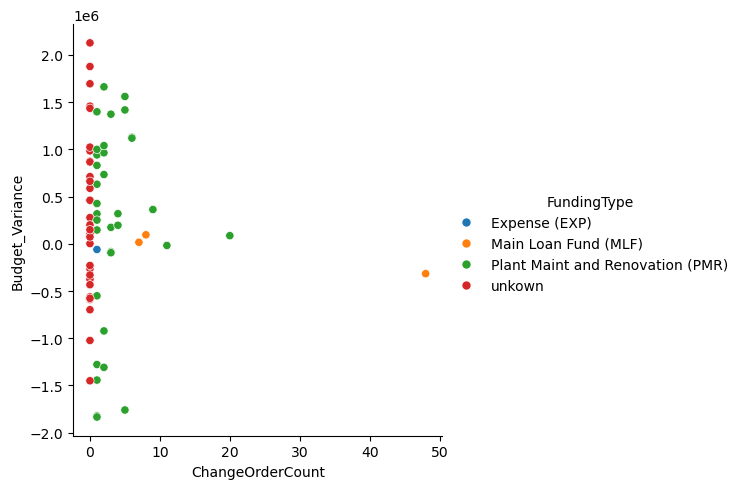

In [24]:
# VIsualized the relation between CHangeOrderCount and Budget_Variance, noting no clear pattern as there is significant grouping, and MLF projects had significant spread
sns.relplot(data=merged, x="ChangeOrderCount", y = "Budget_Variance", hue = "FundingType")

<Axes: xlabel='Budget_Variance'>

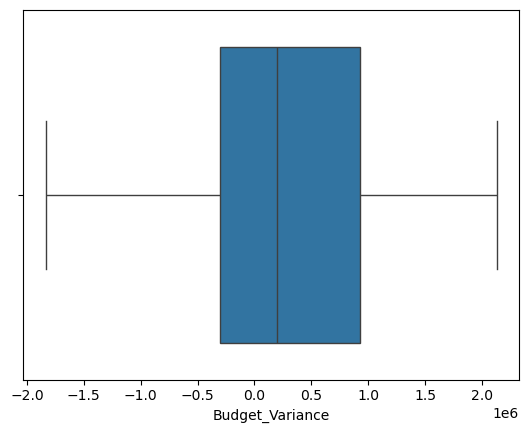

In [25]:
# Used a boxplot to note the Budget_Variation has many outlars, which is expected as the sample size was very small and covered a significant range of project types and sizes was included
sns.boxplot(data = merged, x="Budget_Variance")

In [26]:
# Confirmed all modeling variables have no missing values and are typed correctly
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   OriginalBudget    70 non-null     float64 
 1   Contractor        70 non-null     category
 2   FundingType       70 non-null     category
 3   ChangeOrderCount  70 non-null     float64 
 4   FormCounter       70 non-null     float64 
 5   act_var           70 non-null     float64 
 6   Budget_Variance   70 non-null     float64 
dtypes: category(2), float64(5)
memory usage: 3.9 KB


In [27]:
# Reviewed the quantiative qualities of quantiative variables, confirming the outliars as some quantiles showed significiant jumps in value while others showed minimal to no change
merged.describe()

,OriginalBudget,ChangeOrderCount,FormCounter,act_var,Budget_Variance
count,7.000000e+01,70.000000,70.000000,70.000000,7.000000e+01
mean,5.884170e+05,2.528571,3.328571,-2.275000,2.324138e+05
std,6.937953e+05,6.399097,8.581614,7.917399,9.183601e+05
min,0.000000e+00,0.000000,0.000000,-44.000000,-1.834455e+06
25%,0.000000e+00,0.000000,0.000000,-1.000000,-3.037123e+05
50%,3.217164e+05,1.000000,0.000000,0.000000,1.982850e+05
75%,9.315544e+05,2.000000,3.000000,0.000000,9.245867e+05
max,2.537909e+06,48.000000,55.000000,6.500000,2.127623e+06


In [28]:
# Reviewed correlation, identifying originalbudget and ChangeOrderCount has strong poositive corrrelation along with FormCounter to a moderately positive degree
merged.corr(numeric_only=True)

,OriginalBudget,ChangeOrderCount,FormCounter,act_var,Budget_Variance
OriginalBudget,1.000000,0.006245,0.065373,0.032820,-0.747548
ChangeOrderCount,0.006245,1.000000,0.831289,-0.045719,-0.053380
FormCounter,0.065373,0.831289,1.000000,-0.096888,-0.127148
act_var,0.032820,-0.045719,-0.096888,1.000000,-0.066195
Budget_Variance,-0.747548,-0.053380,-0.127148,-0.066195,1.000000


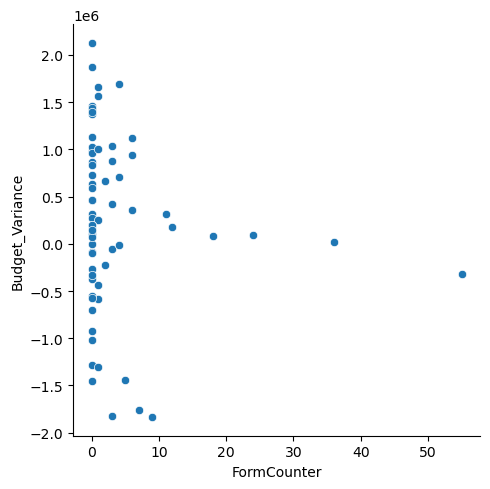

In [29]:
# Visually identifyed no clear pattern between the variance and FormCounter, with areas of strong grouping and outlairs present
sns.relplot(data = merged, x="FormCounter", y="Budget_Variance")
plt.show()

In [30]:
# Using MultiLabelBinarizer to catagorize Contractor as multiple contractors can be present on one project 
merged["Contractor"] = merged["Contractor"].str.split(r",\s*")

mlb = MultiLabelBinarizer()
contractor_encoded = pd.DataFrame(
    mlb.fit_transform(merged["Contractor"]),
    columns=mlb.classes_,
    index=merged.index
)

merged = pd.concat([merged.drop(columns=["Contractor"]), contractor_encoded], axis=1)

In [31]:
# Code Block 34: Merge two dataframes
# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop = 'first')

# OneHotEncoding FundingType
contractor_encoded = pd.DataFrame(
    ohe.fit_transform(merged[["FundingType"]]),  # must be 2D
    columns=ohe.get_feature_names_out(["FundingType"]),
    index=merged.index
)

# Merge back into the original DataFrame
merged = pd.concat([merged.drop(columns=["FundingType"]), contractor_encoded], axis=1)

In [32]:
# Setting the Independant variables and the response variable
y = merged["Budget_Variance"]
X = merged.drop("Budget_Variance", axis=1)

In [33]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state= 42)

In [34]:
# Adding a constant to the OLS model to match further LinearRegression used in modeling
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

In [35]:
# Completing an OLS model
# Identifying a strong adjusted R2 performance, along with variables such as original budget, formcounter, and MLF/PMR as statistically significant
model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Budget_Variance   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4.877
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           6.80e-05
Time:                        01:02:52   Log-Likelihood:                -711.83
No. Observations:                  49   AIC:                             1460.
Df Residuals:                      31   BIC:                             1494.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                              7.377e+05   4.88e+05      1.512      0.141   -2.57e+05    1.73e+06
OriginalBudget                                       -1.1976      0.186     -6.427      0.000      -1.578      -0.818
ChangeOrderCount                                   3.022e+04   9.88e+04      0.306      0.762   -1.71e+05    2.32e+05
FormCounter                                       -1.939e+04   9.99e+04     -0.194      0.847   -2.23e+05    1.84e+05
act_var                                            4136.4950    1.4e+04      0.295      0.770   -2.45e+04    3.28e+04
C&C ELECTRICAL SERVICES LLC - 100167658            6.721e+05   1.34e+06      0.500      0.621   -2.07e+06    3.41e+06
CARROLL DANIEL CONSTRUCTION CO - 100200909        -1.035e+05   1.24e+06     -0.084      0.934   -2.62e+06    2.42e+06
CUMMING MANAGEMENT GROUP INC - 100017347          -3.104e-10   1.49e-09     -0.208      0.837   -3.35e-09    2.73e-09
DG INVESTMENT INTERMEDIATE HOLDINGS 2 - 100021530 -2.672e+05   7.34e+05     -0.364      0.718   -1.76e+06    1.23e+06
EPSTEN GROUP INC - 100152259                        -6.4e+05   1.02e+06     -0.627      0.535   -2.72e+06    1.44e+06
GRESHAM SMITH - 100065499                         -2.268e+05   1.25e+06     -0.182      0.857   -2.77e+06    2.32e+06
GUIDEPOST SOLUTIONS LLC - 100042226                2.347e+05   9.01e+05      0.261      0.796    -1.6e+06    2.07e+06
KC CONSTRUCTION OF GEORGIA INC - 100194403        -1.052e+06    1.3e+06     -0.812      0.423    -3.7e+06    1.59e+06
LEAPLEY CONSTRUCTION GROUP OF ATLANTA - 100109456 -6.091e+05   1.29e+06     -0.472      0.640   -3.24e+06    2.02e+06
MCCARTHY BUILDING COMPANIES INC - 100013473       -1.063e+06   1.72e+06     -0.617      0.542   -4.58e+06    2.45e+06
SOUTHEASTERN COMMERCIAL FLOORING INC - 100092358  -6.584e+05   1.39e+06     -0.474      0.639   -3.49e+06    2.17e+06
TLS ELECTRICAL CO INC - 100022743                 -2.672e+05   7.34e+05     -0.364      0.718   -1.76e+06    1.23e+06
US CAD HOLDINGS LLC - 100177283                   -7.648e-11   1.04e-10     -0.733      0.469   -2.89e-10    1.36e-10
WEBMYERS CONSTRUCTION LLC - 100150242              4.856e+05    1.3e+06      0.372      0.712   -2.17e+06    3.15e+06
YANCEY BROS CO - 100092368                         -4.26e+05   1.38e+06     -0.308      0.760   -3.25e+06    2.39e+06
unkown                                             7721.6451   2.34e+05      0.033      0.974   -4.69e+05    4.85e+05
FundingType_Main Loan Fund (MLF)                           0          0        nan        nan           0           0
FundingType_Plant Maint and Renovation (PMR)         7.3e+05   7.14e+05      1.022      0.315   -7.27e+05    2.19e+06
FundingType_unk

In [36]:
# Preparing for linearRegression
lr = LinearRegression()

In [37]:
# Fitting The training data using LinearRregressuon
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
# Creating predicted results based on the linear model created
y_pred = lr.predict(X_test)

In [39]:
# Calculated root mean squared error
score = root_mean_squared_error(y_test, y_pred)
print(score)

861546.2043036788


In [40]:
# Reviewed coefficients used in the modeling
lr.coef_

array([-1.19764860e+00,  3.02160787e+04, -1.93917509e+04,  4.13649497e+03,
        6.72097317e+05, -1.03451443e+05,  5.82076609e-10, -2.67227861e+05,
       -6.40009591e+05, -2.26797160e+05,  2.34681368e+05, -1.05224684e+06,
       -6.09146943e+05, -1.06254007e+06, -6.58406842e+05, -2.67227861e+05,
        6.98491931e-10,  4.85642430e+05, -4.25993047e+05, -2.38189035e+05,
        0.00000000e+00,  2.38189035e+05, -2.38189035e+05])

In [41]:
# Completing Kfold to better model due to small sample size
kf = KFold(n_splits = 8, shuffle = True, random_state=42)

In [42]:
# Setting the display of the numeric values for more simpistic viewing
np.set_printoptions(suppress=True)

In [43]:
# Calculated the cross validation scores from the Kfold process
cv_score = np.round(cross_val_score(lr, X, y, cv=kf), 2)
print(cv_score)

[ 0.63 -0.38 -3.91 -1.41  0.08  0.06  0.65  0.44]


In [44]:
# Calulated the mean score
print(np.mean(cv_score))

-0.48000000000000004


In [45]:
# Created a pipeline for scaling the data, conducting GridSearchCV, with the score calculated once completed
steps = [("scaler", StandardScaler()),
         ("lr", LinearRegression())]

pipeline = Pipeline(steps)
params = {"lr__fit_intercept" : [True,False]}
tuning = GridSearchCV(pipeline, param_grid = params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

tuning.score(X_test, y_test)

-0.08710292614394466

In [46]:
# Created monte carlo simulation function for future use
def monte_carlo_var(model, base_input, feature_stds, n_simulations=10000, confidence_levels=[95, 99]):
    simulated_preds = []

    for _ in range(n_simulations):
        noisy_input = base_input.copy()
        for col in base_input.columns:
            std = feature_stds.get(col, 0)
            noisy_input[col] += np.random.normal(0, std)
        pred = model.predict(noisy_input)[0]
        simulated_preds.append(pred)

    # created VAR results values for each iteration
    var_results = {
        f"VaR_{level}": np.percentile(simulated_preds, 100 - level)
        for level in confidence_levels
    }

    return var_results, simulated_preds

In [47]:
# Created list including information from each iteration, and creating a dataframe to pull from for review once completed  for analysis
var_records = []

for idx, row in X_test.iterrows():
    base_input = row.to_frame().T  
    var_result, _ = monte_carlo_var(
        model=tuning,
        base_input=base_input,
        feature_stds=X_train.std(), 
        n_simulations=1000           
      
    )
    var_result["ProjectID"] = idx  
    var_records.append(var_result)

var_df = pd.DataFrame(var_records)

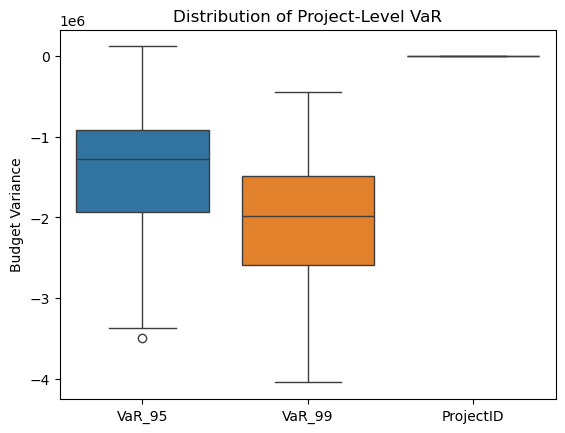

In [48]:
# Boxplot identified most projects would have a negative VaR
# VaR_99 is generally more negative, reflecting larger potential losses at higher confidence levels.
# Several outliars are present that should be investigated futher
sns.boxplot(data=var_df)
plt.title("Distribution of Project-Level VaR")
plt.ylabel("Budget Variance")
plt.show()

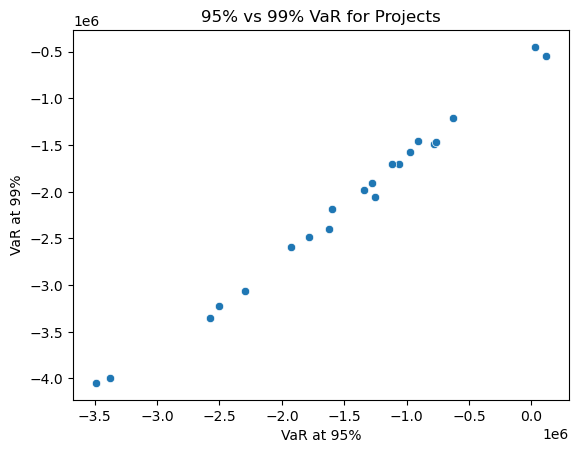

In [49]:
# The near-linear clustering identifies a strong positive correlatiion
# Suggests there are no projects that are safe at 95% but risky at 99%, both would have simular risk portfolios
# One project at the top right has a very large potential variance in both cases
sns.scatterplot(x=var_df["VaR_95"], y=var_df["VaR_99"])
plt.title("95% vs 99% VaR for Projects")
plt.xlabel("VaR at 95%")
plt.ylabel("VaR at 99%")
plt.show()

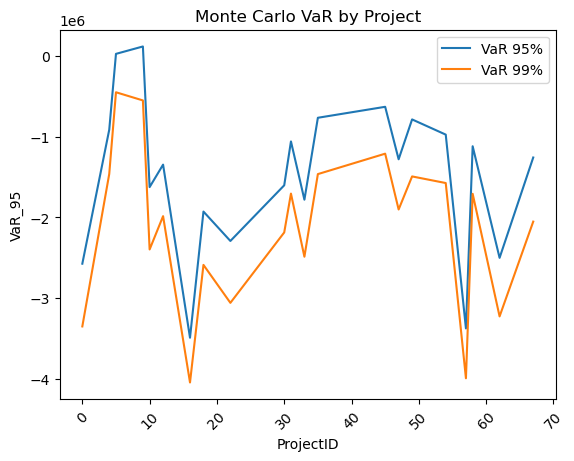

In [50]:
# Most proejcts showed a simular VaR range around -1.25, but at least 5 projects are identfiied as high risk due to the significant deviation from the typical value
# These deviations can represent uncertanty or volatility and shoudl be futher reviewed 
sns.lineplot(data=var_df, x="ProjectID", y="VaR_95", label="VaR 95%")
sns.lineplot(data=var_df, x="ProjectID", y="VaR_99", label="VaR 99%")
plt.xticks(rotation=45)
plt.title("Monte Carlo VaR by Project")
plt.legend()
plt.show()

# Findings
#### Distribution of Project-Level VaR (Boxplot)

Interpretation:

    The distributions of VaR at 95% and 99% are broadly similar, both centered around a negative variance (≈ –1.25M).

    Both tails contain outliers, showing that some projects have much larger downside risk exposure than the majority.

    The negative median suggests most projects are expected to face unfavorable budget variances (losses) at both confidence levels.

Finding:

    Most projects carry comparable risk exposure, but a subset have extreme downside potential that warrants closer monitoring.

    Projects in the tail risk zone could drive major budget overruns if not controlled.



####  95% vs 99% VaR for Projects (Scatterplot)

Interpretation:

    There is a strong positive correlation between 95% and 99% VaR. Projects that are risky at 95% are consistently risky at 99%.

    No projects are "safe" at 95% but risky at 99%, which indicates consistent risk profiles across confidence levels.

    A few projects deviate significantly from the cluster, showing greater sensitivity to tail risk.

Finding:

    Risk exposure scales consistently with stricter confidence levels, making the risk forecasts reliable.

    Outliers with large gaps between 95% and 99% VaR highlight projects that could experience volatility under stress scenarios — these should be flagged for additional scenario analysis.

####  Monte Carlo VaR by Project (Line Plot across ProjectIDs)

Interpretation:

    Most projects hover around the same VaR level (≈ –1.25M), confirming that baseline downside risk is similar across the portfolio.

    At least 5–6 projects show extreme deviations (sharp dips or spikes), reflecting higher uncertainty or unique risk drivers.

    The gap between VaR 95% and VaR 99% is relatively small for most projects, but widens for high-risk ones, showing greater exposure to tail risk.

Finding:

    Portfolio-wide risk is relatively stable, but a minority of projects are disproportionately risky and could dominate overall budget uncertainty.

    These projects should be prioritized for risk mitigation, cost contingency allocation, and management oversight.

### Overall Insights

    Baseline downside risk is consistent across most projects (≈ –1.25M), which aids in stable financial forecasting.

    Outlier projects exhibit extreme tail risk that could destabilize portfolio budgets — they should be subject to tighter cost controls.

    Consistency across 95% and 99% VaR supports confidence in the modeling approach, though the widening gap in risky projects underscores the need for stress testing.

    This analysis allows management to target risk management efforts efficiently, focusing on the handful of projects driving outsized downside exposure.
significant in both models.

# Next Steps / Recommendations
#### Deep Dive on Extreme Projects

    Cluster or segment analysis: Identify whether high-risk projects share common features (size, duration, contractor, funding source, etc.).

    Scenario stress testing: Run project-specific simulations to see how shocks (cost overruns, delays, supply chain risk) impact the VaR distribution.

    Qualitative review: Cross-check whether outlier projects have known management, technical, or external risk factors.

#### Improve Model Robustness

Address non-normality & heavy tails:

    Your diagnostics (Omnibus, JB, skew, kurtosis) suggest non-normal residuals and fat tails.

    Consider models that better capture variance clustering and tails (e.g., GARCH-type, quantile regression, or heavy-tailed distributions like Student-t).

Check multicollinearity: The high Condition Number (7.36e+21) signals severe multicollinearity. You might:

    Standardize inputs,

    Use PCA or dimensionality reduction, or

    Apply regularization (Ridge/Lasso).

Improve error structure: If residual autocorrelation exists (Durbin-Watson is near 2, so not terrible but worth checking lags), consider time-series models if data are sequential.

#### Portfolio-Level Risk Management

Contingency allocation: Use the VaR results to allocate contingency budgets dynamically (heavier buffers for outlier projects).

Diversification analysis: Assess whether combining projects offsets risk or whether risks are correlated (i.e., portfolio VaR vs. sum of individual VaRs).

Monitoring framework: Establish periodic re-calculation of VaR as project forecasts are updated (rolling risk monitoring).

#### Model Validation & Communication

Backtesting VaR: Compare predicted VaR against realized cost overruns to evaluate calibration.

Sensitivity analysis: Show how changes in input assumptions shift VaR estimates (important for stakeholder trust).

Stakeholder reporting: Summarize risks not just with numbers but with heatmaps or dashboards highlighting “high-risk” projects.